In [1]:
from datetime import date

print("Last run date:", date.today())

Last run date: 2023-05-04


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

import lib.figs_funcs as figfunc
import lib.fun_plotting as fun_plotting
import lib.funcs_ko as funcs_ko
import lib.NetAnalysis as na
import lib.funcs_general as funcs_general

import os
current_path = os.getcwd()

%load_ext autoreload
%autoreload 2

In [3]:
# matplotlib.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
# matplotlib.rc('text', usetex=True)

matplotlib.rc('text', usetex=True)
sns.set(font='Avenir')
sns.set(style="white")

In [4]:
path = "/Users/cleliacorridori/Dropbox_2021 Dropbox/Jorah Mormont/GRN_Inference/" # for Mac
path_data = path+"DATA/"

In [5]:
imp_genes = np.loadtxt(path_data+"general_info/imp_genes.csv", dtype="str")
imp_genes

array(['Klf4', 'Klf2', 'Esrrb', 'Tfcp2l1', 'Tbx3', 'Stat3', 'Tcf7l1',
       'Nanog', 'Sall4', 'Pou5f1', 'Sox2', 'Dnmt3a', 'Dnmt3b', 'Utf1',
       'Otx2', 'Etv5', 'Etv4', 'Nr0b1', 'Zic3', 'Lef1', 'Tcf15', 'Gbx2',
       'Pou3f1', 'Rbpj'], dtype='<U7')

In [6]:
# GENE CLASSIFICATION
naive = ["Klf4", "Klf2", "Esrrb", "Tfcp2l1", "Tbx3", "Stat3", "Nanog", "Sox2"]
formative = ["Nr0b1", "Zic3", "Rbpj", "Utf1", "Etv4", "Tcf15"]
committed = ["Dnmt3a", "Dnmt3b", "Lef1", "Otx2", "Pou3f1", "Etv5"]

genes_order = np.concatenate((naive, formative, committed))
nc_genes = np.setdiff1d(imp_genes, genes_order)
genes_order = np.concatenate((genes_order, nc_genes))

In [7]:
# Fixed threshold for mini-bulk rolling average
mb_wind = 150


# Check on Knrown interactions

## Neighbours Interactions

In [8]:
TPtrial_list = ["Stat3 Klf4 1", "Nanog Esrrb 1", "Stat3 Dnmt3b -1", 
                "Nanog Otx2 -1", "Nanog Pou3f1 -1",
                "Stat3 Gbx2 1", "Stat3 Tfcp2l1 1", # "Stat3 Stat3 1"
                "Otx2 Pou3f1 1", "Otx2 Dnmt3a 1", 
                "Tcf7l1 Esrrb -1", "Tcf7l1 Klf2 -1", "Tcf7l1 Nanog -1", "Tcf7l1 Nr0b1 -1",  "Tcf7l1 Tfcp2l1 -1",  
                "Rbpj Nanog -1", "Rbpj Tbx3 -1", "Etv5 Lef1 1", "Etv5 Pou3f1 1"]


# PST + MB Data Loading

In [9]:
# Mini-Bulk
# load the Gene Expression data log normalized + Pseudo-Time: the columns are the cells and the rows are the genes
# df_lN_mb_pst = pd.read_csv(path_data + "GE_data/processed/imp_genes_LogNorm_PST_MB.csv", header=0, index_col=0, sep=",")

# load the Gene Expression data Psi Normalized + Pseudo-Time: the columns are the cells and the rows are the genes
df_lN_mb_pst = pd.read_csv(path_data + "GE_data/processed/imp_genes_PsiNorm_PST_MB.csv", header=0, index_col=0, sep=",")


print("LogNorm dims: ", df_lN_mb_pst.shape)

LogNorm dims:  (24, 8124)


In [10]:
data_LN = df_lN_mb_pst.copy()
data_LN.columns = np.arange(0,len(data_LN.columns))
data_LN.index = np.arange(0,len(data_LN.index))

data_LN.head(3)

,0,1,2,3,4,5,6,7,8,9,...,8114,8115,8116,8117,8118,8119,8120,8121,8122,8123
0,0.742050,0.753709,0.753709,0.753709,0.767439,0.750540,0.734958,0.744650,0.744650,0.764925,...,0.141278,0.141278,0.133910,0.135940,0.128608,0.128608,0.128608,0.128608,0.128608,0.128608
1,0.932831,0.938236,0.954685,0.947056,0.947056,0.947521,0.939299,0.948991,0.948991,0.946581,...,0.404834,0.404834,0.404834,0.414851,0.414851,0.424114,0.424114,0.416087,0.407699,0.400793
2,0.188526,0.188526,0.188526,0.188526,0.188526,0.188526,0.180303,0.180303,0.180303,0.166094,...,0.203270,0.195377,0.195377,0.187391,0.187391,0.187391,0.187391,0.187391,0.187391,0.180485


## Save the Initial vector for SIMULATION


In [11]:
saving = False
n_cells = 1000 # s.t. it is stable (we have 2000 time points in 2iL state)

# Creating a column of integers from 0 to the length of the series
df_saving_index = pd.DataFrame(range(len(genes_order))).set_index(genes_order)

# concatenating the series and the index
result = pd.concat([df_saving_index, df_lN_mb_pst.iloc[:,:n_cells].mean(axis=1)], axis=1)
result
if saving:
    # Saving the resulting DataFrame as a tab-separated text file named 'result.txt'
    result.to_csv(path_data+"OUT_SCODE_PN/initial_GE_PsiNorm_MB.txt", sep='\t', index=False, header=False)


## PST Data


number of time steps: 8124


/var/folders/2z/hsgwjl3d49109llzgvkyf6jw0000gn/T/ipykernel_98493/3090624795.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  PST_df_new = PST_df_new.drop(PST_df_new[(PST_df["time"] == "24h") & (PST_df_new["pst"] < 8.0)].index)
/var/folders/2z/hsgwjl3d49109llzgvkyf6jw0000gn/T/ipykernel_98493/3090624795.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  PST_df_new = PST_df_new.drop(PST_df_new[(PST_df["time"] == "06h") & (PST_df_new["pst"] < 8.0)].index)
/var/folders/2z/hsgwjl3d49109llzgvkyf6jw0000gn/T/ipykernel_98493/3090624795.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  PST_df_new = PST_df_new.drop(PST_df_new[(PST_df["time"] == "12h") & (PST_df_new["pst"] < 8.0)].index)


,time,pst
0,0,0.100720
1,0,0.101643
2,0,0.102494


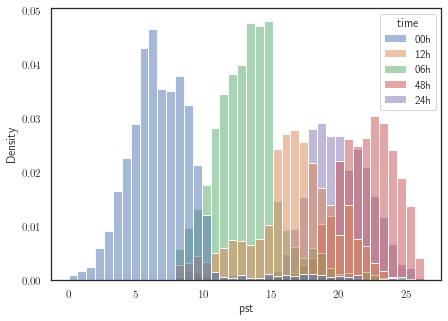

In [12]:
PST_df = pd.read_csv(path_data+'input_data/cellinfo_pseudotime_UMAPno2clcs_23_01_13.txt',
                              header = 0, sep = ' ', quotechar = '"', 
                              names = ["barcodes", "time", "pst"])

# sorting in ascending values of pseudo-time
PST_df = PST_df.sort_values(by=['pst'])

PST_df_new = PST_df.drop(PST_df[(PST_df["time"] == "48h") & (PST_df["pst"] < 8.0)].index)
PST_df_new = PST_df_new.drop(PST_df_new[(PST_df["time"] == "24h") & (PST_df_new["pst"] < 8.0)].index)
PST_df_new = PST_df_new.drop(PST_df_new[(PST_df["time"] == "06h") & (PST_df_new["pst"] < 8.0)].index)
PST_df_new = PST_df_new.drop(PST_df_new[(PST_df["time"] == "12h") & (PST_df_new["pst"] < 8.0)].index)


plt.figure(figsize=(7,5))
sns.histplot(data=PST_df_new, x="pst", hue="time", stat="density", bins=40)

data_PST= PST_df_new.replace("00h", int(0)).replace("06h", int(6)).replace("12h", int(12)).replace("24h", int(24)).replace("48h", int(48))
data_PST = data_PST.iloc[:,1:] #remove Barcodes

#normalize pst between 0 and 1
data_PST["pst"]=data_PST["pst"]/(data_PST["pst"].max())

# rolling average as for GE data
data_PST = data_PST.rolling(window=mb_wind, axis=0).mean().dropna(axis=0)
data_PST["time"] = data_PST["time"].astype('int')

# rename indices
data_PST.index = np.arange(0,len(data_PST.index))
print("number of time steps:", data_PST.shape[0])
data_PST.head(3)




## Check on RSS (100 trials)

In [13]:
# Train and Test
training_data = data_LN.sample(frac=0.8, random_state=2407, replace=False, axis=1)
testing_data  = data_LN.drop(training_data.columns, axis=1)

training_time = data_PST.loc[training_data.columns, :]
testing_time  = data_PST.drop(training_data.columns, axis=0)

print(training_data.shape[1]+testing_data.shape[1])
print(training_data.shape, testing_data.shape)
print(training_time.shape, testing_time.shape)


8124
(24, 6499) (24, 1625)
(6499, 2) (1625, 2)


# Matrices computation

In [14]:
# # path1 =  path+"1_NetworkInference/"

# # Train part with more executions
# genes = 24
# D = [2,3,4,6,8]
# cells_train = 6499
# cells_test = 1625
# iters = 100
# data_GE  = training_data
# data_PST = training_time
# Nexp=100

# for jj in range(len(D)):
#     print("D: ", D[jj])
#     for ii in range(Nexp):
#         print("Exp ", ii)
#         out="OUT_SCODE_PsiNorm/PST_MB/out_z"+str(D[jj])+"/exp_"+str(ii)
# #         if not os.path.isdir(out):
# #             os.makedirs(out)
        
#         # Train
#         ! Rscript ~/Downloads/SCODE-master/SCODE.R /Users/cleliacorridori/Dropbox_2021\ Dropbox/Jorah\ Mormont/Code/Work/1_NetworkInference/IN_SCODE/PST_MB/train_data.txt /Users/cleliacorridori/Dropbox_2021\ Dropbox/Jorah\ Mormont/Code/Work/1_NetworkInference/IN_SCODE/PST_MB/train_time.txt {out} {genes} {D[jj]} {cells_train} {iters}
#         # Test
#         out_file = "OUT_SCODE_PsiNorm/PST_MB/out_z"+str(D[jj])+"/exp_"+str(ii)+"/RSS_test.txt"
#         ! Rscript ~/Downloads/SCODE-master/RSS.R /Users/cleliacorridori/Dropbox_2021\ Dropbox/Jorah\ Mormont/Code/Work/1_NetworkInference/IN_SCODE/PST_MB/test_data.txt /Users/cleliacorridori/Dropbox_2021\ Dropbox/Jorah\ Mormont/Code/Work/1_NetworkInference/IN_SCODE/PST_MB/test_time.txt {out} {out_file} {genes} {D[jj]} {cells_test}
        


# Results Evaluation

In [15]:
# initialize variables
genes = 24
D = [2,3,4,6,8]
cells_train = 6499 # 80% of cells for training
cells_test = 1625  # 20% of cells for testing
iters = 100        # number of iterations to minimize the error (fixed by the authors, not discussed in the paper)
Nexp=100           # number of experiments

RSS_vect = np.zeros((len(D), Nexp))
RSS_quantile = np.zeros((3,len(D)))

A_sample = np.zeros((genes, genes, len(D), Nexp))
for jj in range(len(D)):
    print("D: ", D[jj])
    for ii in range(Nexp):
        out=       path_data+"OUT_SCODE_PN/PST_MB/out_z"+str(D[jj])+"/exp_"+str(ii)
        out_file = path_data+"OUT_SCODE_PN/PST_MB/out_z"+str(D[jj])+"/exp_"+str(ii)+"/RSS_test.txt"
        RSS_vect[jj,ii] = np.array(pd.read_csv(out_file, sep="\t", header=None))
        A_sample[:,:,jj,ii] = pd.read_csv(out+"/A.txt", sep="\t", header=None)
        
    RSS_quantile[:,jj] = np.array([np.quantile(RSS_vect[jj,:], 0.25), np.quantile(RSS_vect[jj,:], 0.5), np.quantile(RSS_vect[jj,:], 0.75)])


D:  2
D:  3
D:  4
D:  6
D:  8


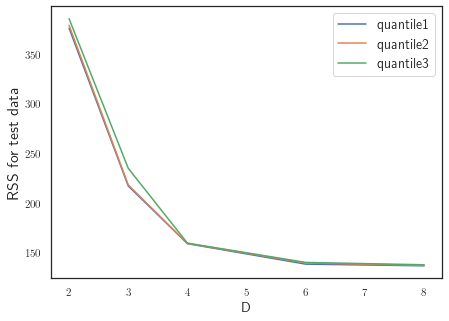

In [16]:
plt.figure(figsize=(7,5))
for ii in range(RSS_quantile.shape[0]):
    plt.plot(D, RSS_quantile[ii,:], label="quantile"+str(ii+1))
    plt.legend(fontsize=14)
    plt.ylabel("RSS for test data", fontsize=16)
    plt.xlabel("D", fontsize=14)    

In [17]:
# for each D: reordering in ascending order of RSS and then take the 50 smallest RSS
A_sel = np.zeros((genes, genes, len(D), 50))
A_lin = np.zeros((genes*genes, len(D), 50))

for jj in range(len(D)):
    idx = np.argsort(RSS_vect[jj,:])[:50]  
    for ii in range(len(idx)):
        A_sel[:,:,jj,ii] = A_sample[:,:,jj,idx[ii]]
        A_lin[:,jj,ii] = A_sample[:,:,jj,idx[ii]].flatten()
        
    


In [18]:
A_quantile = np.zeros((3,len(D)))
for jj in range(len(D)):
    A_exp_corr = np.corrcoef(A_lin[:,jj,:].T)
#     print(np.quantile(A_exp_corr, 0.25))
    A_quantile[:,jj] = np.array([np.quantile(A_exp_corr, 0.25), np.quantile(A_exp_corr, 0.5), np.quantile(A_exp_corr, 0.75)])


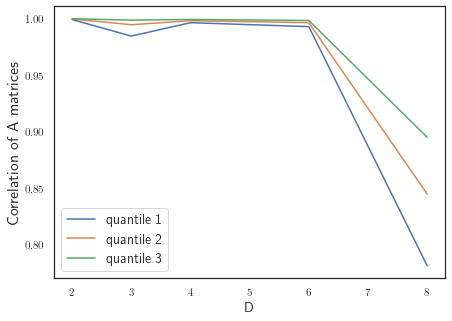

In [19]:
plt.figure(figsize=(7,5))
for ii in range(A_quantile.shape[0]):
    plt.plot(D, A_quantile[ii,:], label="quantile "+str(ii+1))
    plt.legend(fontsize=14)
    plt.ylabel("Correlation of A matrices", fontsize=16)
    plt.xlabel("D", fontsize=14) 

# Inferred Matrix with D=6

In [20]:
# select D
DD = 3
print("D=", D[DD])

# Number of best inferred networks
N_sel_A = 50

# threshold for selecting links (interaction values)
sel_thr = 0.01
print("thr=", sel_thr)

# averaging over the best 50 networks
A_tot = np.sum(A_sel[:,:,DD,:N_sel_A], axis=2)/N_sel_A

D= 6
thr= 0.01


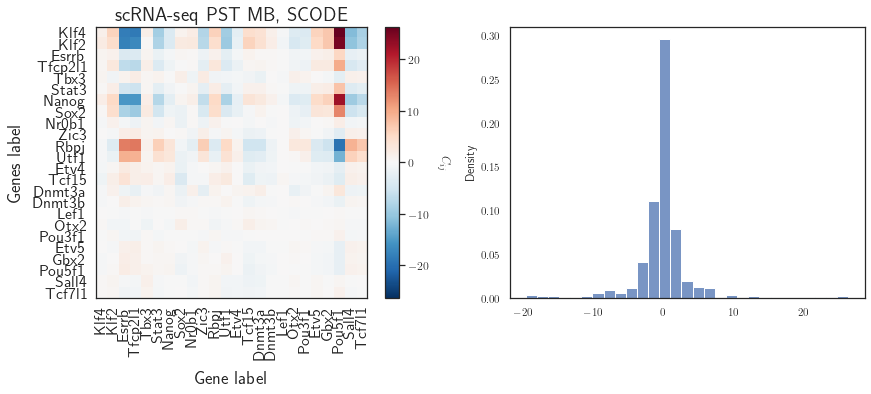

TP fraction  0.5
Not Normalized TRUE interactions [-0.   -0.    0.   -0.41 -0.    0.57 -0.    0.   -0.   -1.61 -8.12 -7.06
 -0.57 -3.03  0.   -0.9  -0.    0.39]
Normalized TRUE interactions [-0.   -0.    0.   -0.02 -0.    0.02 -0.    0.   -0.   -0.06 -0.31 -0.27
 -0.02 -0.11  0.   -0.03 -0.    0.01]
Not Normalized interactions [-8.94 -0.6   0.41 -0.41 -0.19  0.57 -3.54  0.15 -1.97 -1.61 -8.12 -7.06
 -0.57 -3.03  5.2  -0.9  -0.06  0.39]
Normalized interactions [-0.34 -0.02  0.02 -0.02 -0.01  0.02 -0.13  0.01 -0.07 -0.06 -0.31 -0.27
 -0.02 -0.11  0.2  -0.03 -0.    0.01]


In [21]:
# plot inferred network       
TP_fraction, TP_info, interaction_matrix = funcs_general.TP_plot(TPtrial_list, A_tot, genes_order, inferred_int_thr=sel_thr, 
                                                   Norm_Matx = False, data_type="scRNA-seq PST MB, SCODE",
                                                   figplot=True, nbin=30, 
                                                    verbose=False, Norm=True)                                                                  

print("TP fraction ", TP_fraction)

print("Not Normalized TRUE interactions", np.round(TP_info[2,:]*TP_info[3,:],2))
print("Normalized TRUE interactions", np.round(TP_info[2,:]*TP_info[3,:]/np.max(np.abs(A_tot)), 2))

print("Not Normalized interactions", np.round(TP_info[2,:],2))
print("Normalized interactions", np.round(TP_info[2,:]/np.max(np.abs(A_tot)), 2))


### Fraction of discarded

In [22]:
high_meanMatx_thr = na.to_thr_matrix(A_tot, thr=sel_thr)
print(1-(len(np.where(high_meanMatx_thr==0)[0]))/(24**2))
print("FRACTION OF DISCARDED", (len(np.where(high_meanMatx_thr==0)[0]))/(24**2))

print(len(np.where(A_tot==0)[0]))

0.7986111111111112
FRACTION OF DISCARDED 0.2013888888888889
0


In [23]:
saving = False
if saving:
    np.savetxt(path_data+"OUT_SCODE_PN/A_sel_PsiNorm_MB.txt",A_tot)


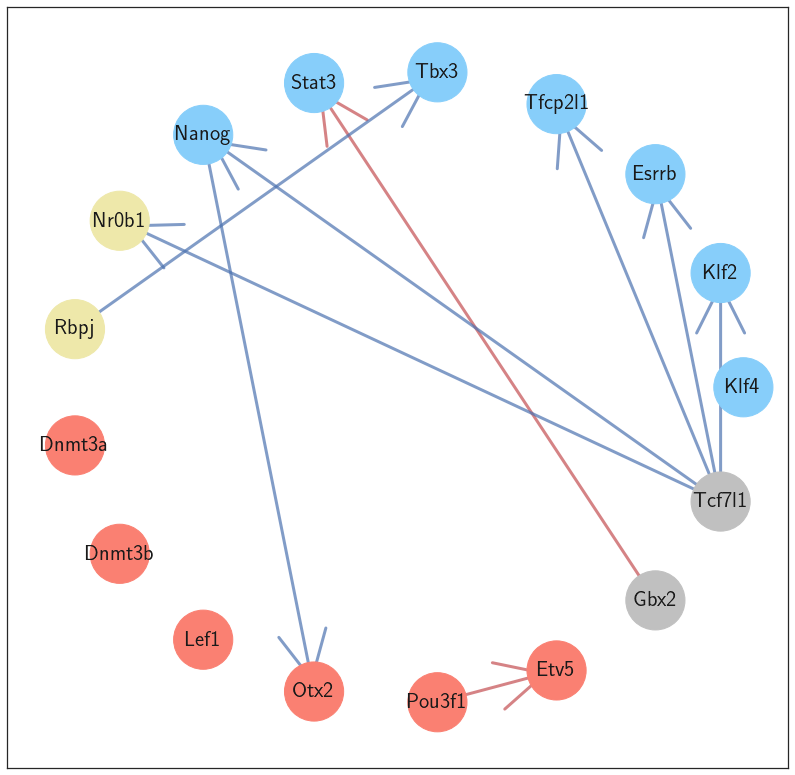

In [24]:
adj_matx = na.to_adj_matrix(A_tot, thr = 0.01)
Interactions_list = TPtrial_list

naive_ref = ["Klf4", "Klf2", "Esrrb", "Tfcp2l1", "Tbx3", "Stat3", "Nanog", "Sox2"]
formative_early_ref = ["Nr0b1", "Zic3", "Rbpj"]
formative_late_ref = ["Utf1", "Etv4", "Tcf15", "Dnmt3a", "Dnmt3b", "Lef1", "Otx2", "Pou3f1", "Etv5"]

# na.visualize_graphTrue(adj_matx, genes_order, naive_ref, formative_early_ref, formative_late_ref, Interactions_list,"")# "Expected Interactions (Known Directed Correlations)")   

# na.visualize_graphSelTrue(adj_matx, genes_order, naive_ref, formative_early_ref, formative_late_ref, Interactions_list,"")
na.visualize_graphSel(adj_matx, genes_order, naive_ref, formative_early_ref, formative_late_ref, Interactions_list,"")


# Dynamic Simulation - Data Generation

In [25]:
matplotlib.rc('text', usetex=True)
sns.set(font='Avenir')
sns.set(style="white")

In [26]:
compute = False
N_sim=500
df_sim = np.zeros((len(genes_order), 101, N_sim))

for ii in range(N_sim):
    if ii%100==0:
        print("Exp ", ii)
    out_sim = "/Users/cleliacorridori/Dropbox_2021\ Dropbox/Jorah\ Mormont/GRN_Inference/DATA/OUT_SCODE_PN/KO_PN/NO_KO/out_simSCODE_PsiNorm_MB_"+str(ii)+".txt"

    if compute:
        # call R script Reconstruct_dynamics.R
        ! Rscript /Users/cleliacorridori/Dropbox_2021\ Dropbox/Jorah\ Mormont/GRN_Inference/GRN_Inference_CODE/Reconstruct_dynamics.R /Users/cleliacorridori/Dropbox_2021\ Dropbox/Jorah\ Mormont/GRN_Inference/DATA/OUT_SCODE_PN/initial_GE_PsiNorm_MB.txt /Users/cleliacorridori/Dropbox_2021\ Dropbox/Jorah\ Mormont/GRN_Inference/DATA/OUT_SCODE_PN/A_sel_PsiNorm_MB.txt {out_sim} {24}

    # load simulated data
    df_sim[:,:,ii] = pd.read_table(path_data+"OUT_SCODE_PN/KO_PN/NO_KO/out_simSCODE_PsiNorm_MB_"+str(ii)+".txt", delimiter="\t", dtype={"Value": float}).set_index(genes_order)
    df_sim[df_sim<0]=0
    

Exp  0
Exp  100
Exp  200
Exp  300
Exp  400


In [27]:
# # simulating WT
# df_sim_avg, df_sim_std = funcs_ko.WT_avg_w(df_sim)
# df_sim_std = (df_sim.std(axis=1)/np.sqrt(df_sim.shape[1]))[:,0]

# # experimental WT
# df_avg = data_LN.mean(axis=1)
# df_std = data_LN.std(axis=1)/np.sqrt(data_LN.shape[1])

## Average GE

In [28]:
df_sim.shape
prova = df_sim.reshape((df_sim.shape[0], df_sim.shape[1]*df_sim.shape[2]))
print(prova.shape)

(24, 50500)


(2, 24)
(2, 24)


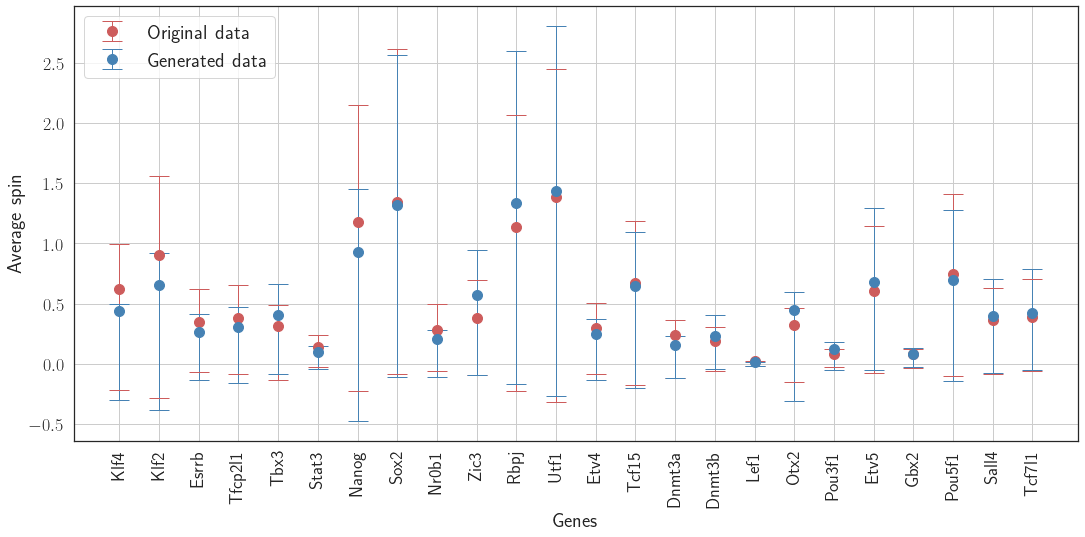

In [29]:
# plot the average activity of the genes  
fig, ax = plt.subplots(1,1, figsize=(18,8))
avg_activity_lN, avg_activity_std_lN         = funcs_ko.plot_activity(data_LN, genes_order, "Original data", "indianred", ax)
avg_activity_lN_sim, avg_activity_std_lN_sim = funcs_ko.plot_activity_simulated(df_sim, genes_order, "Generated data", "steelblue", ax)
plt.xticks(rotation=90, fontsize=18)
plt.yticks( fontsize=18)
plt.show()

### Significance of the average values

In [30]:
# # number of sigma considered
# N_sigma = 3

# # compute the difference between the original and simulated spins values
# diff_activity_lN = np.zeros(len(avg_activity_lN))
# diff_activity_lN_std = np.zeros(len(avg_activity_lN))
# count = 0
# for i in range(len(avg_activity_lN)):
#     diff_activity_lN[i] = (avg_activity_lN[i] - avg_activity_lN_sim[i])
#     diff_activity_lN_std[i] = np.sqrt(avg_activity_std_lN[i]**2 + avg_activity_std_lN_sim[i]**2)
#     if np.abs(diff_activity_lN[i]) < N_sigma * diff_activity_lN_std[i]:
#         # print("gene: ", genes_order[i], " has a difference of: ", diff_activity_lN[i], " std: ", N_sigma * diff_activity_lN_std[i])
#         count += 1

# plt.figure(figsize=(22,8))
# plt.errorbar(genes_order, diff_activity_lN, yerr=N_sigma*diff_activity_lN_std, fmt='o', color='black', label = "Differences between WT and KO with "+str(N_sigma)+"$\sigma$")
# plt.axhline(y=0, color='r', linestyle='-', label= " zero")
# plt.legend(fontsize=18, loc="upper left")
# plt.xticks(rotation=90, fontsize=18)
# plt.yticks(fontsize=18)

# print("fraction of significant", count/len(genes_order))

## Correlation Matrices

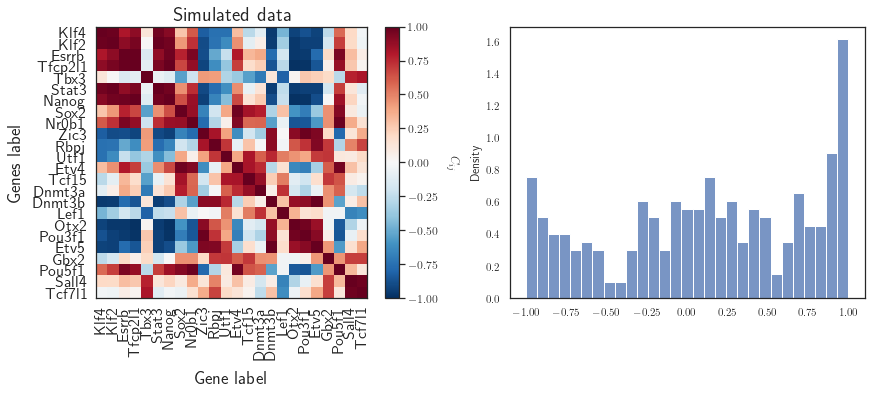

In [31]:
cm_sim = np.zeros((df_sim.shape[0], df_sim.shape[0], df_sim.shape[2]))
for ii in range(df_sim.shape[2]):
    cm_sim[:,:, ii] = np.corrcoef(df_sim[:,:,ii])
cm_sim_SCODE_PST_MB_pN_Cont = np.mean(cm_sim, axis=2)
# cm_sim_SCODE_PST_MB_pN_Cont = np.corrcoef(df_sim)

bins = np.linspace(-1, 1, 30)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
figfunc.plotmat(cm_sim_SCODE_PST_MB_pN_Cont, fig, ax[0], genes_order, "Simulated data")
sns.histplot(np.ndarray.flatten(cm_sim_SCODE_PST_MB_pN_Cont), bins=bins,  ax=ax[1], stat="density")
plt.show()

# # plt.imshow(np.corrcoef(spins_new_lN))
# print(np.where(spins_sim==float("nan")))



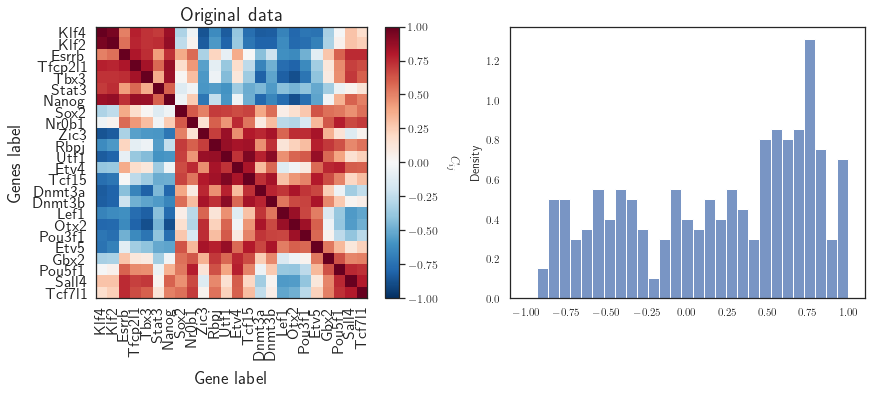

In [32]:
cm_pst_mb_psiNorm = np.corrcoef(data_LN)

bins = np.linspace(-1, 1, 30)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
figfunc.plotmat(cm_pst_mb_psiNorm, fig, ax[0], genes_order, "Original data")
sns.histplot(np.ndarray.flatten(cm_pst_mb_psiNorm), bins=bins,  ax=ax[1], stat="density")
plt.show()

### Random Correlation Matrix

In [33]:
N_rows = data_LN.shape[0]
N_cols = data_LN.shape[1]
Ntest=500
# Linearize
val_rnd = np.reshape(np.array(data_LN), (N_cols*N_rows))

# reshuflle for Ntest times
df_pN_mb_pst_shuffle = np.zeros((Ntest, N_rows, N_cols))

for ii in range(Ntest):
    np.random.seed(1234+ii)
    # Random reshuffle of the binnarized GE data
    np.random.shuffle(val_rnd)
    val_rnd_matx = val_rnd.reshape(N_rows,N_cols) ########################
    trial_long = pd.DataFrame(val_rnd_matx)

    # Save the shuffled DataFrame
    df_pN_mb_pst_shuffle[ii,:,:] = trial_long

corr_matxs_rnd = np.array([np.corrcoef(df_pN_mb_pst_shuffle[i,:,:]) for i in range(Ntest)])


In [34]:
noise_dist = [funcs_ko.sum_squared_abs_diff(cm_pst_mb_psiNorm, corr_matxs_rnd[i,:,:]) for i in range(Ntest)]

noise_dist = np.mean(noise_dist)

result_SO = funcs_ko.sum_squared_abs_diff(cm_pst_mb_psiNorm, cm_sim_SCODE_PST_MB_pN_Cont)/noise_dist
print(f"Scode - Orig {result_SO:.2f}")


Scode - Orig 0.86


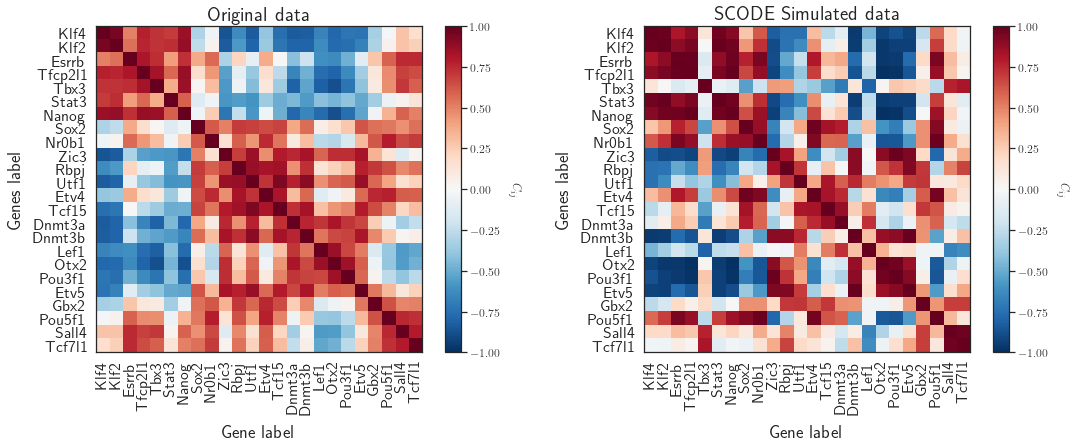

In [35]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
# figfunc.plotmat(corr_matxs_rnd_lN_noDiag, fig, ax[0], genes_order, "Random data")
figfunc.plotmat(cm_pst_mb_psiNorm, fig, ax[0], genes_order, "Original data", fix = True)
figfunc.plotmat(cm_sim_SCODE_PST_MB_pN_Cont, fig, ax[1], genes_order, "SCODE Simulated data", fix = True)
plt.show()



In [36]:
# np.savetxt('cm_sim_SCODE_MB_PsiNorm.txt', cm_sim_SCODE_PST_MB_pN_Cont)

## Clustering Generated Data

### Generated Data

/var/folders/2z/hsgwjl3d49109llzgvkyf6jw0000gn/T/ipykernel_98493/225457357.py:10: UserWarning: Use the colorbar set_ticks() method instead.
  plt.xticks([])
/var/folders/2z/hsgwjl3d49109llzgvkyf6jw0000gn/T/ipykernel_98493/225457357.py:11: UserWarning: Use the colorbar set_ticks() method instead.
  plt.yticks([])


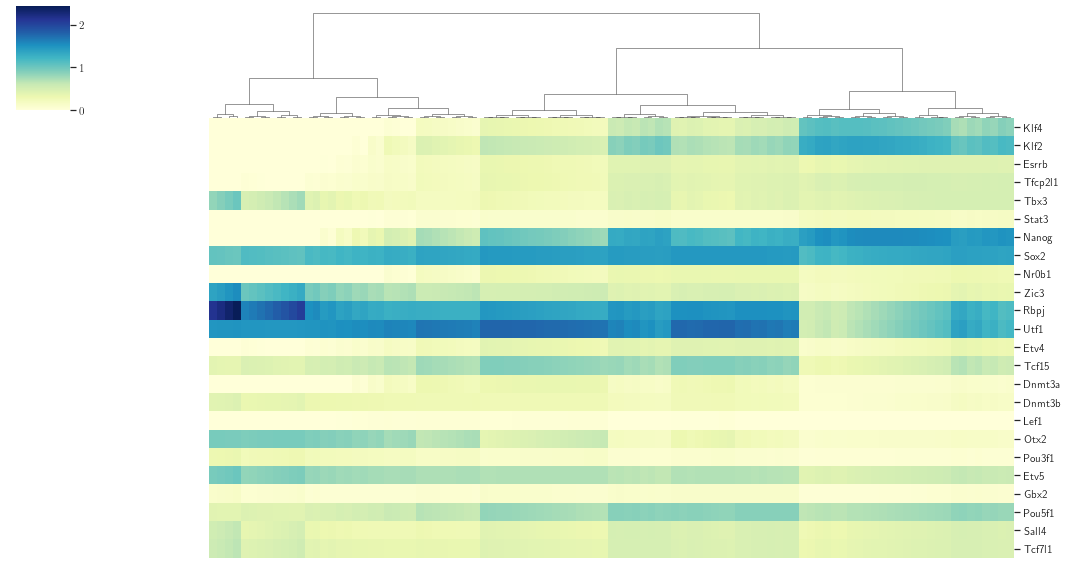

In [37]:
# Perform linkage on your numpy array
import scipy
jj=0
Z = scipy.cluster.hierarchy.linkage(df_sim[:,:,jj].T, method='ward')

# Note: we are showing just one simulated dataset, but you can do the same for all of them

# Plot the dendrogram and heatmap
sns.clustermap(df_sim[:,:, jj], col_linkage=Z, cmap='YlGnBu', yticklabels=genes_order, cbar=True, figsize=(15,8), row_cluster=False, xticklabels=False )
plt.xticks([])
plt.yticks([])
plt.show()


### Original Data

/var/folders/2z/hsgwjl3d49109llzgvkyf6jw0000gn/T/ipykernel_98493/4282739962.py:10: UserWarning: Use the colorbar set_ticks() method instead.
  plt.xticks([])
/var/folders/2z/hsgwjl3d49109llzgvkyf6jw0000gn/T/ipykernel_98493/4282739962.py:11: UserWarning: Use the colorbar set_ticks() method instead.
  plt.yticks([])


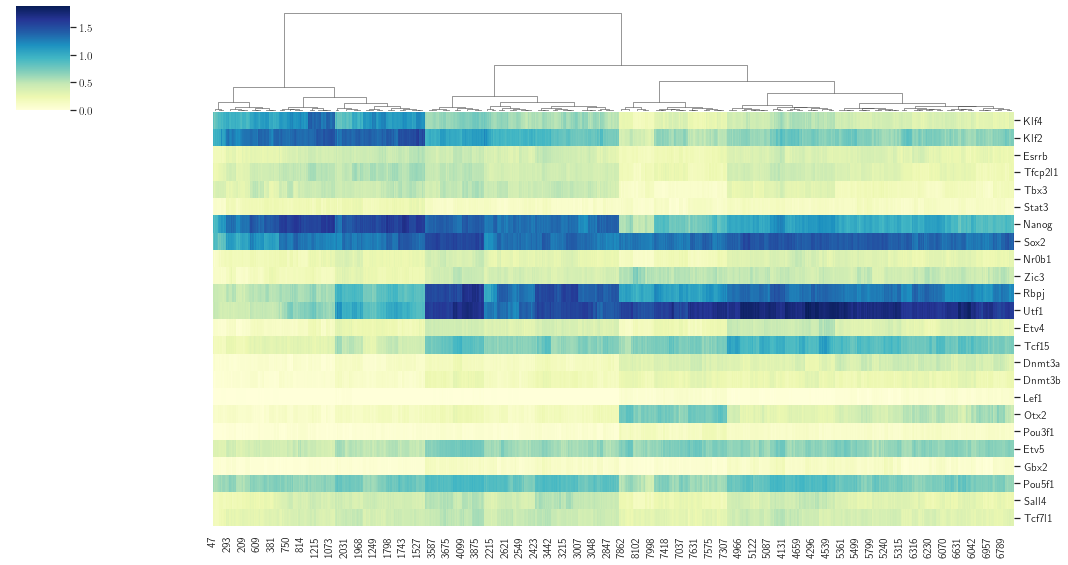

In [38]:
# Perform linkage on your numpy array
import scipy
jj=0
Z = scipy.cluster.hierarchy.linkage(data_LN.T, method='ward')

# Note: we are showing just one simulated dataset, but you can do the same for all of them

# Plot the dendrogram and heatmap
sns.clustermap(data_LN, col_linkage=Z, cmap='YlGnBu',yticklabels=genes_order,cbar=True, figsize=(15,8), row_cluster=False,  )
plt.xticks([])
plt.yticks([])
plt.show()


<AxesSubplot:>

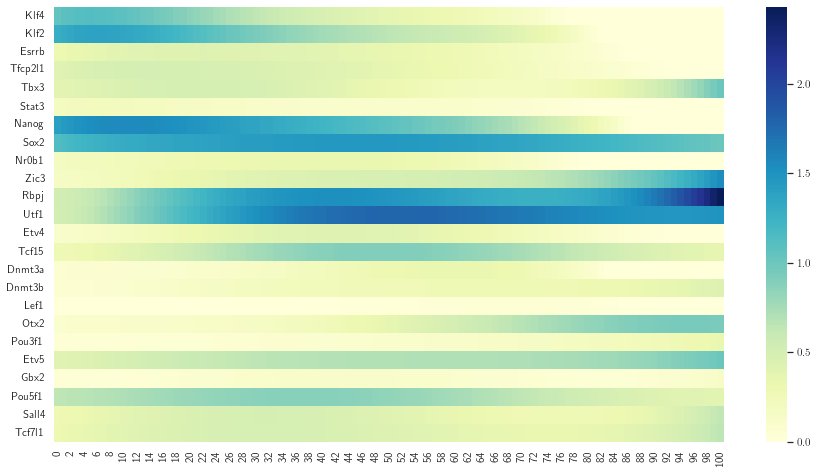

In [39]:
## Data visualization
jj=0

plt.figure(figsize=(15,8))
sns.heatmap(df_sim[:,:,jj], cmap='YlGnBu',yticklabels=genes_order)

<AxesSubplot:>

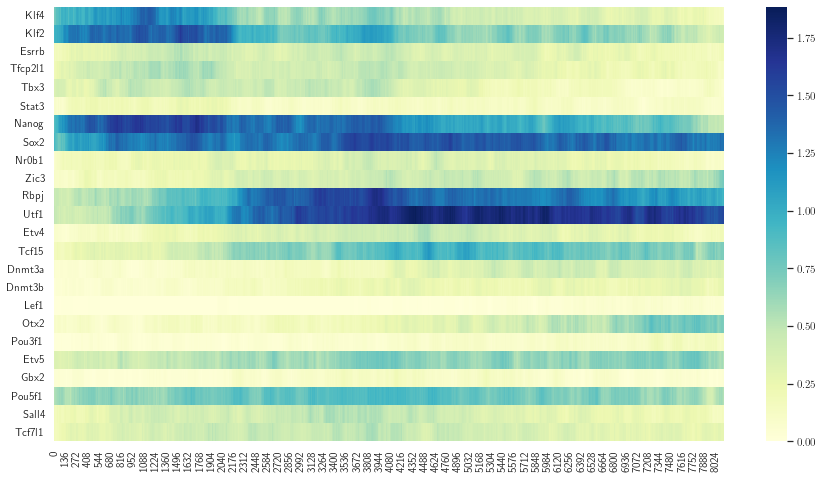

In [40]:
## Data visualization
jj=0

plt.figure(figsize=(15,8))
sns.heatmap(data_LN, cmap='YlGnBu',yticklabels=genes_order)

# KO

## Leeb data

In [41]:
df_KO_N24_Leeb_uncl = pd.read_csv(path_data+'Leeb_Data_Orig/df_KO_N24_uncleaned.csv', index_col=0, header=0)
df_KO_N24_Leeb_uncl.head(2)

,Rbpj,Etv5,Tcf7l1
Klf4,2.890194,2.386695,1.300426
Klf2,0.492426,1.008604,2.338680


## Functions

In [42]:
def KO_comparison_ExpVsSim(lofFC_Exp, logFC_Sim, N_test=100):
    """compute the fraction of Experimental Data end Simulated data in Agreement"""
    comparison= np.array([np.sign(lofFC_Exp)*np.sign(logFC_Sim[ii,:]) for ii in range(N_test)])
#     print(np.sum([len(np.where(logFC_Sim[:,ii]==0)[0]) for ii in range(N_test)]))
    data_considered = np.array([len(np.where(comparison[ii,:]!=0)[0]) for ii in range(N_test)])
    
    in_agreement = np.array([len(np.where(comparison[ii,:]==1)[0])/data_considered[ii] for ii in range(N_test)])
    no_agreement = np.array([len(np.where(comparison[ii,:]==-1)[0])/data_considered[ii] for ii in range(N_test)])
    mean_in_agreement = np.mean(in_agreement)
    
    # Check
    check_sum = np.array([in_agreement[ii]+no_agreement[ii] for ii in range(N_test)])-1
    check = np.where(check_sum>0.001)[0]
    if check.size > 0:
        print("Error in comparison Exp and Sim")
    return(mean_in_agreement,    data_considered)


In [43]:
def KO_plotLogFC_ExpAndSim(lofFC_Exp, logFC_Sim, KO_genes_order):
    plt.figure(figsize=(18,5))
    plt.plot(lofFC_Exp, 
             "o",ms = 10, label="Exp")
    plt.plot(logFC_Sim[:,0],  
             "o", ms = 10,
             color="darkred", label= "Sim")
    plt.xticks(np.arange(0,23),KO_genes_order)
    plt.axhline(0)
    plt.legend()

In [ ]:
df_sim_avg, df_sim_std = funcs_ko.WT_avg_w(df_sim)
df_sim_std = (df_sim.std(axis=1)/np.sqrt(df_sim.shape[1]))[:,0]


## Rpbj

In [49]:
# get the initial gene expression and the KO interaction matrix to simulate the KO data
KO_gene = "Rbpj"
KO_gene_idk = np.where(genes_order ==KO_gene)[0][0]

# KO_lN_rec_matx = np.delete(lN_rec_matx, KO_gene_idk, axis=0)
KO_pN_rec_matx = np.delete(A_tot, KO_gene_idk, axis=0)
KO_pN_rec_matx = np.delete(KO_pN_rec_matx, KO_gene_idk, axis=1)

KO_genes_order_R = np.delete(genes_order, KO_gene_idk, axis=0)

KO_result = result.drop(KO_gene)
KO_result.to_csv(path_data+"OUT_SCODE_PN/KO_PN/RBPJ/initial_GE_PsiNorm_MB_KO.txt", sep='\t', index=False, header=False)

# np.savetxt(path_data+ "OUT_SCODE_PN/KO_PN/RBPJ/A_KO_PsiNorm_MB.txt",KO_pN_rec_matx)

KO_R_wt_avg = np.delete(np.array(df_sim_avg),KO_gene_idk, axis=0)
KO_R_wt_std = np.delete(np.array(df_sim_std),KO_gene_idk, axis=0)



In [50]:
compute = False
N_sim=500
KO_df_sim = np.zeros((len(KO_genes_order_R), 101, N_sim))

for ii in range(N_sim):
    if ii%50==0:
        print("Exp ", ii)
    out_sim = "/Users/cleliacorridori/Dropbox_2021\ Dropbox/Jorah\ Mormont/GRN_Inference/DATA/OUT_SCODE_PN/KO_PN/RBPJ/OUT/out_simSCODE_PsiNorm_MB_"+str(ii)+".txt"

    if compute == True:
        # call R script Reconstruct_dynamics.R
        ! Rscript /Users/cleliacorridori/Dropbox_2021\ Dropbox/Jorah\ Mormont/GRN_Inference/GRN_Inference_CODE/Reconstruct_dynamics.R /Users/cleliacorridori/Dropbox_2021\ Dropbox/Jorah\ Mormont/GRN_Inference/DATA/OUT_SCODE_PN/KO_PN/RBPJ/initial_GE_PsiNorm_MB_KO.txt /Users/cleliacorridori/Dropbox_2021\ Dropbox/Jorah\ Mormont/GRN_Inference/DATA/OUT_SCODE_PN/KO_PN/RBPJ/A_KO_PsiNorm_MB.txt {out_sim} {23}

    # load simulated data
    KO_df_sim[:,:,ii] = pd.read_table(path_data+"OUT_SCODE_PN/KO_PN/RBPJ/OUT/out_simSCODE_PsiNorm_MB_"+str(ii)+".txt", delimiter="\t", dtype={"Value": float}).set_index(KO_genes_order_R)
    KO_df_sim[KO_df_sim<0]=0
    

Exp  0
Exp  50
Exp  100
Exp  150
Exp  200
Exp  250
Exp  300
Exp  350
Exp  400
Exp  450


In [51]:
# compute the average and std of the simulated  KO data
KO_R_df_sim_avg, KO_R_df_sim_std = funcs_ko.WT_avg_w(KO_df_sim)
KO_R_df_sim_std = (np.std(KO_df_sim, axis=1)/np.sqrt(KO_df_sim.shape[1]))[:,0]

KO_R_diff, KO_R_diff_std, KO_R_idx_notS = funcs_ko.KO_diff_sim(KO_R_df_sim_avg, KO_R_df_sim_std ,KO_R_wt_avg, KO_R_wt_std, thr_significance=3)
# print("differences in the simulated data", KO_R_diff)
# print("error in the simulated data", KO_R_diff_std)
# print("index of genes not significantly different", KO_R_idx_notS.shape)

# funcs_ko.KO_plots_avgAct_SCODE(KO_R_df_sim_avg, KO_R_df_sim_std, KO_R_wt_avg, KO_R_wt_std, KO_genes_order_R, N_sigma=1)


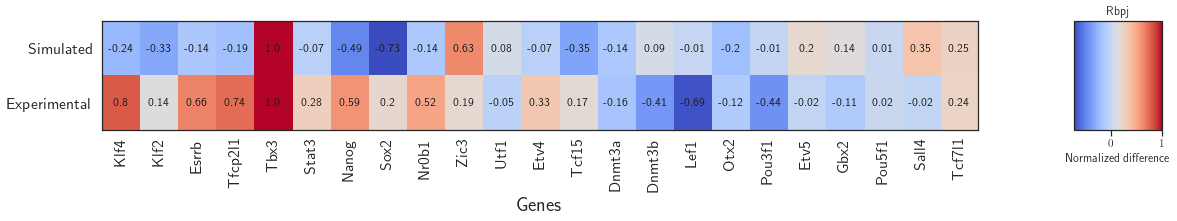

In [52]:
logFC_Leeb_R = np.delete(np.array(df_KO_N24_Leeb_uncl[KO_gene]), KO_gene_idk) # logFC Leeb

funcs_ko.KO_heat_comparison_T(KO_R_diff, logFC_Leeb_R, "Rbpj", KO_genes_order_R, Norm=True)


## Etv5

In [53]:
KO_gene = "Etv5"
KO_gene_idk = np.where(genes_order == KO_gene)[0][0]

# KO_lN_rec_matx = np.delete(lN_rec_matx, KO_gene_idk, axis=0)
KO_pN_rec_matx = np.delete(A_tot, KO_gene_idk, axis=0)
KO_pN_rec_matx = np.delete(KO_pN_rec_matx, KO_gene_idk, axis=1)

KO_genes_order_E = np.delete(genes_order, KO_gene_idk, axis=0)

KO_result = result.drop(KO_gene)
KO_result.to_csv(path_data+"OUT_SCODE_PN/KO_PN/ETV5/initial_GE_PsiNorm_MB_KO.txt", sep='\t', index=False, header=False)

# np.savetxt(path_data+ "OUT_SCODE_PN/KO_PN/ETV5/A_KO_PsiNorm_MB.txt",KO_pN_rec_matx)

KO_E_wt_avg = np.delete(np.array(df_sim_avg),KO_gene_idk, axis=0)
KO_E_wt_std = np.delete(np.array(df_sim_std),KO_gene_idk, axis=0)


In [54]:
compute = False
N_sim=500
KO_df_sim = np.zeros((len(KO_genes_order_E), 101, N_sim))

for ii in range(N_sim):
    if ii%50==0:
        print("Exp ", ii)
    out_sim = "/Users/cleliacorridori/Dropbox_2021\ Dropbox/Jorah\ Mormont/GRN_Inference/DATA/OUT_SCODE_PN/KO_PN/ETV5/OUT/out_simSCODE_PsiNorm_MB_"+str(ii)+".txt"

    if compute == True:
        # call R script Reconstruct_dynamics.R
        ! Rscript /Users/cleliacorridori/Dropbox_2021\ Dropbox/Jorah\ Mormont/GRN_Inference/GRN_Inference_CODE/Reconstruct_dynamics.R /Users/cleliacorridori/Dropbox_2021\ Dropbox/Jorah\ Mormont/GRN_Inference/DATA/OUT_SCODE_PN/KO_PN/ETV5/initial_GE_PsiNorm_MB_KO.txt /Users/cleliacorridori/Dropbox_2021\ Dropbox/Jorah\ Mormont/GRN_Inference/DATA/OUT_SCODE_PN/KO_PN/ETV5/A_KO_PsiNorm_MB.txt {out_sim} {23}

    # load simulated data
    KO_df_sim[:,:,ii] = pd.read_table(path_data+"OUT_SCODE_PN/KO_PN/ETV5/OUT/out_simSCODE_PsiNorm_MB_"+str(ii)+".txt", delimiter="\t", dtype={"Value": float}).set_index(KO_genes_order_E)
    KO_df_sim[KO_df_sim<0]=0
    

Exp  0
Exp  50
Exp  100
Exp  150
Exp  200
Exp  250
Exp  300
Exp  350
Exp  400
Exp  450


index of genes not significantly different (1,)


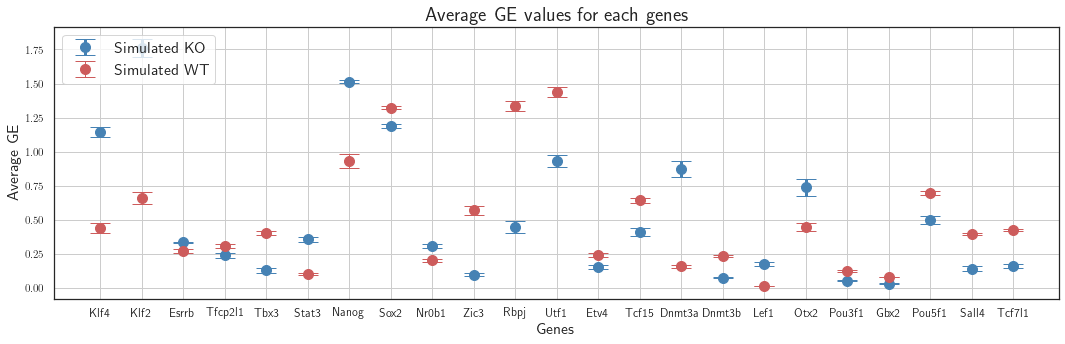

In [55]:
# compute the average and std of the simulated  KO data
KO_E_df_sim_avg, KO_E_df_sim_std = funcs_ko.WT_avg_w(KO_df_sim)
KO_E_df_sim_std = (np.std(KO_df_sim, axis=1)/np.sqrt(KO_df_sim.shape[1]))[:,0]


KO_E_diff, KO_E_diff_std, KO_E_idx_notS = funcs_ko.KO_diff_sim(KO_E_df_sim_avg, KO_E_df_sim_std ,KO_E_wt_avg, KO_E_wt_std, thr_significance=3)

print("index of genes not significantly different", KO_E_idx_notS.shape)

funcs_ko.KO_plots_avgAct_SCODE(KO_E_df_sim_avg, KO_E_df_sim_std, KO_E_wt_avg, KO_E_wt_std, KO_genes_order_E, N_sigma=1)

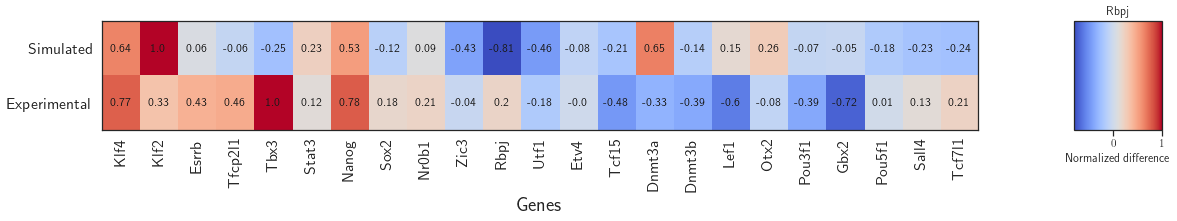

In [56]:
logFC_Leeb_E = np.delete(np.array(df_KO_N24_Leeb_uncl[KO_gene]), KO_gene_idk) # logFC Leeb

funcs_ko.KO_heat_comparison_T(KO_E_diff, logFC_Leeb_E, "Rbpj", KO_genes_order_E, Norm=True)


## Tcf7l1

In [57]:
KO_gene = "Tcf7l1"
KO_gene_idk = np.where(genes_order ==KO_gene)[0][0]

# KO_lN_rec_matx = np.delete(lN_rec_matx, KO_gene_idk, axis=0)
KO_pN_rec_matx = np.delete(A_tot, KO_gene_idk, axis=0)
KO_pN_rec_matx = np.delete(KO_pN_rec_matx, KO_gene_idk, axis=1)

KO_genes_order_T = np.delete(genes_order, KO_gene_idk, axis=0)

KO_result = result.drop(KO_gene)
KO_result.to_csv(path_data+"OUT_SCODE_PN/KO_PN/TCF7L1/initial_GE_PsiNorm_MB_KO.txt", sep='\t', index=False, header=False)

# np.savetxt(path_data+ "OUT_SCODE_PN/KO_PN/TCF7L1/A_KO_PsiNorm_MB.txt",KO_pN_rec_matx)

KO_T_wt_avg = np.delete(np.array(df_sim_avg),KO_gene_idk, axis=0)
KO_T_wt_std = np.delete(np.array(df_sim_std),KO_gene_idk, axis=0)


In [58]:
compute = False
N_sim=500
KO_df_sim = np.zeros((len(KO_genes_order_T), 101, N_sim))

for ii in range(N_sim):
    if ii%50==0:
        print("Exp ", ii)
    out_sim = "/Users/cleliacorridori/Dropbox_2021\ Dropbox/Jorah\ Mormont/GRN_Inference/DATA/OUT_SCODE_PN/KO_PN/TCF7L1/OUT/out_simSCODE_PsiNorm_MB_"+str(ii)+".txt"

    if compute==True:
        # call R script Reconstruct_dynamics.R
        ! Rscript /Users/cleliacorridori/Dropbox_2021\ Dropbox/Jorah\ Mormont/GRN_Inference/GRN_Inference_CODE/Reconstruct_dynamics.R /Users/cleliacorridori/Dropbox_2021\ Dropbox/Jorah\ Mormont/GRN_Inference/DATA/OUT_SCODE_PN/KO_PN/TCF7L1/initial_GE_PsiNorm_MB_KO.txt /Users/cleliacorridori/Dropbox_2021\ Dropbox/Jorah\ Mormont/GRN_Inference/DATA/OUT_SCODE_PN/KO_PN/TCF7L1/A_KO_PsiNorm_MB.txt {out_sim} {23}

    # load simulated data
    KO_df_sim[:,:,ii] = pd.read_table(path_data+"OUT_SCODE_PN/KO_PN/TCF7L1/OUT/out_simSCODE_PsiNorm_MB_"+str(ii)+".txt", delimiter="\t", dtype={"Value": float}).set_index(KO_genes_order_T)
    KO_df_sim[KO_df_sim<0]=0
    

Exp  0
Exp  50
Exp  100
Exp  150
Exp  200
Exp  250
Exp  300
Exp  350
Exp  400
Exp  450


index of genes not significantly different (9,)


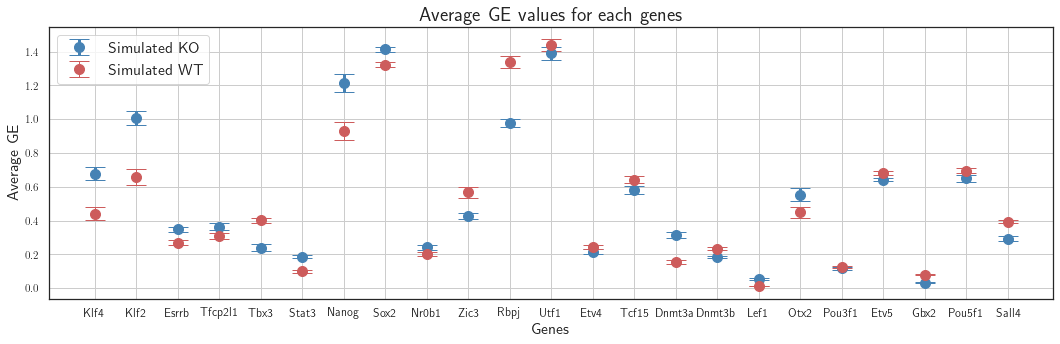

In [59]:
# compute the average and std of the simulated  KO data
KO_T_df_sim_avg, KO_T_df_sim_std = funcs_ko.WT_avg_w(KO_df_sim)
KO_T_df_sim_std = (np.std(KO_df_sim, axis=1)/np.sqrt(KO_df_sim.shape[1]))[:,0]

KO_T_diff, KO_T_diff_std, KO_T_idx_notS = funcs_ko.KO_diff_sim(KO_T_df_sim_avg, KO_T_df_sim_std ,KO_T_wt_avg, KO_T_wt_std, thr_significance=3)

print("index of genes not significantly different", KO_T_idx_notS.shape)

funcs_ko.KO_plots_avgAct_SCODE(KO_T_df_sim_avg, KO_T_df_sim_std, KO_T_wt_avg, KO_T_wt_std, KO_genes_order_T, N_sigma=1)

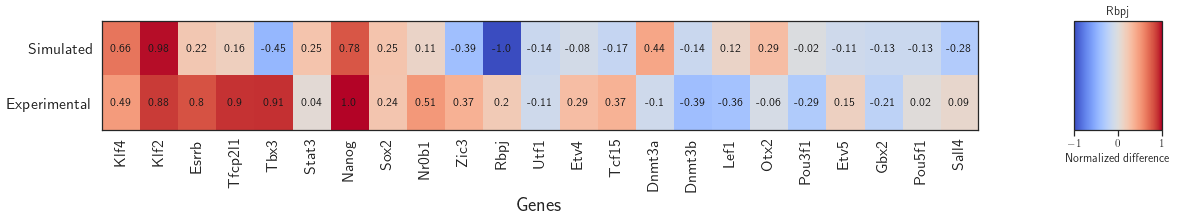

In [60]:
logFC_Leeb_T = np.delete(np.array(df_KO_N24_Leeb_uncl[KO_gene]), KO_gene_idk) # logFC Leeb

funcs_ko.KO_heat_comparison_T(KO_T_diff, logFC_Leeb_T, "Rbpj", KO_genes_order_T, Norm=True)


# Three KO

In [61]:
KO_gene = ["Rbpj", "Etv5", "Tcf7l1"]
KO_gene_idk = [np.where(genes_order == KO_gene[i])[0][0]  for i in range(len(KO_gene))]


KO_pN_rec_matx = np.delete(A_tot, KO_gene_idk, axis=0)
KO_pN_rec_matx = np.delete(KO_pN_rec_matx, KO_gene_idk, axis=1)

KO_genes_order = np.delete(genes_order, KO_gene_idk, axis=0)

KO_result = result.drop(KO_gene)
KO_result.to_csv(path_data+"OUT_SCODE_PN/KO_PN/MULT/initial_GE_PsiNorm_MB_KO.txt", sep='\t', index=False, header=False)

# np.savetxt(path_data+ "OUT_SCODE_PN/KO_PN/MULT/A_KO_PsiNorm_MB.txt",KO_pN_rec_matx)

KO_Th_wt_avg = np.delete(np.array(df_sim_avg),KO_gene_idk, axis=0)
KO_Th_wt_std = np.delete(np.array(df_sim_std),KO_gene_idk, axis=0)

In [62]:
compute = False
N_sim=500
KO_df_sim = np.zeros((len(KO_genes_order), 101, N_sim))
for ii in range(N_sim):
    if ii%50==0:
        print("Exp ", ii)
    out_sim = "/Users/cleliacorridori/Dropbox_2021\ Dropbox/Jorah\ Mormont/GRN_Inference/DATA/OUT_SCODE_PN/KO_PN/MULT/OUT/out_simSCODE_PsiNorm_MB_"+str(ii)+".txt"

    if compute==True:
        # call R script Reconstruct_dynamics.R
        ! Rscript /Users/cleliacorridori/Dropbox_2021\ Dropbox/Jorah\ Mormont/GRN_Inference/GRN_Inference_CODE/Reconstruct_dynamics.R /Users/cleliacorridori/Dropbox_2021\ Dropbox/Jorah\ Mormont/GRN_Inference/DATA/OUT_SCODE_PN/KO_PN/MULT/initial_GE_PsiNorm_MB_KO.txt /Users/cleliacorridori/Dropbox_2021\ Dropbox/Jorah\ Mormont/GRN_Inference/DATA/OUT_SCODE_PN/KO_PN/MULT/A_KO_PsiNorm_MB.txt {out_sim} {21}

    # load simulated data
    KO_df_sim[:,:,ii] = pd.read_table(path_data+"OUT_SCODE_PN/KO_PN/MULT/OUT/out_simSCODE_PsiNorm_MB_"+str(ii)+".txt", delimiter="\t", dtype={"Value": float}).set_index(KO_genes_order)
    KO_df_sim[KO_df_sim<0]=0
    


Exp  0
Exp  50
Exp  100
Exp  150
Exp  200
Exp  250
Exp  300
Exp  350
Exp  400
Exp  450


In [63]:
# compute the average and std of the simulated  KO data
KO_Th_df_sim_avg, KO_Th_df_sim_std = funcs_ko.WT_avg_w(KO_df_sim)
KO_Th_df_sim_std = (np.std(KO_df_sim, axis=1)/np.sqrt(KO_df_sim.shape[1]))[:,0]


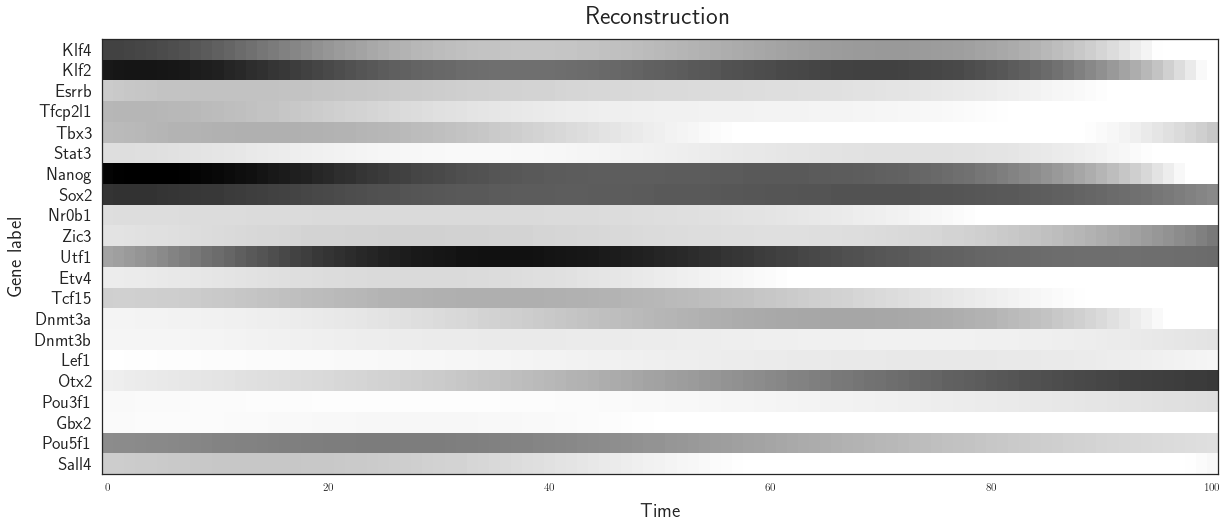

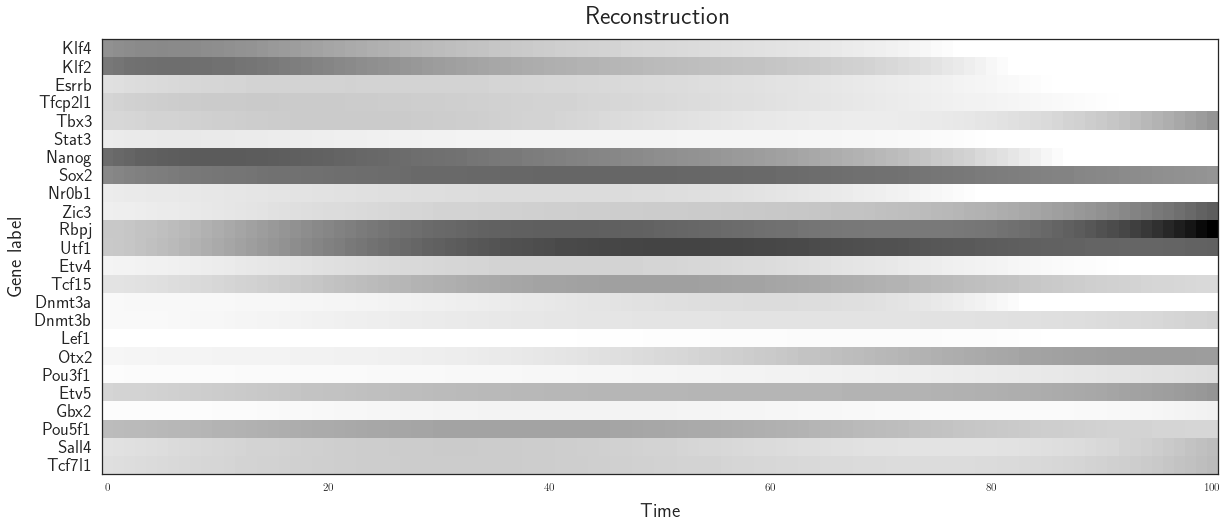

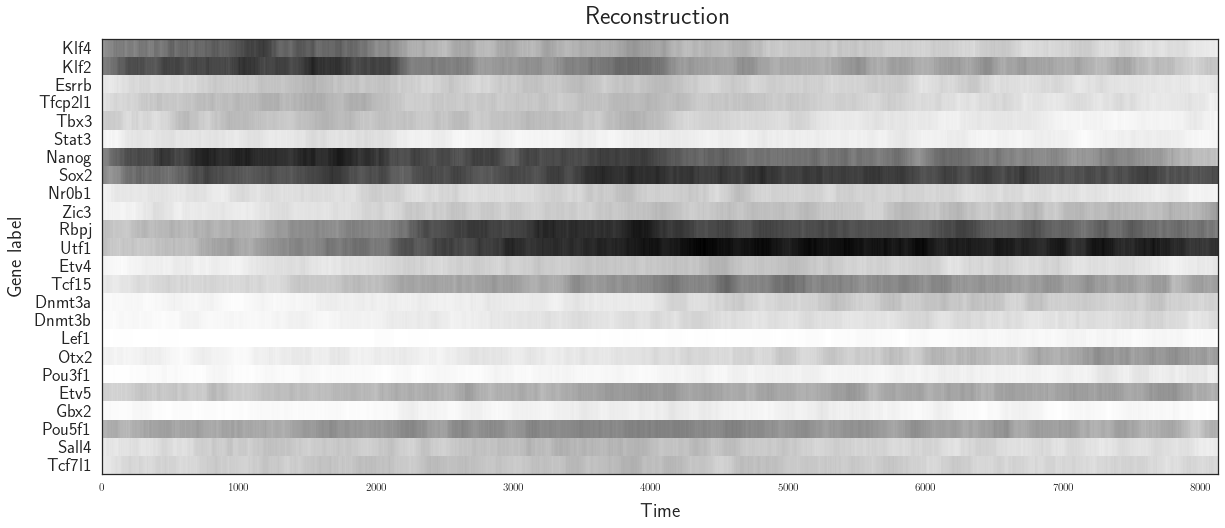

In [64]:
fun_plotting.raster_plot(KO_df_sim[:,:,0], 'Reconstruction', 1, KO_genes_order)
plt.show()

fun_plotting.raster_plot(df_sim[:,:,0], 'Reconstruction', 1, genes_order)
plt.show()

fun_plotting.raster_plot(np.array(df_lN_mb_pst), 'Reconstruction', 1, genes_order)
plt.show()

index of genes not significantly different [ 0  5  6 16]
number of genes significantly different (17,)
['Klf2' 'Esrrb' 'Tfcp2l1' 'Tbx3' 'Sox2' 'Nr0b1' 'Zic3' 'Utf1' 'Etv4'
 'Tcf15' 'Dnmt3a' 'Dnmt3b' 'Lef1' 'Pou3f1' 'Gbx2' 'Pou5f1' 'Sall4']


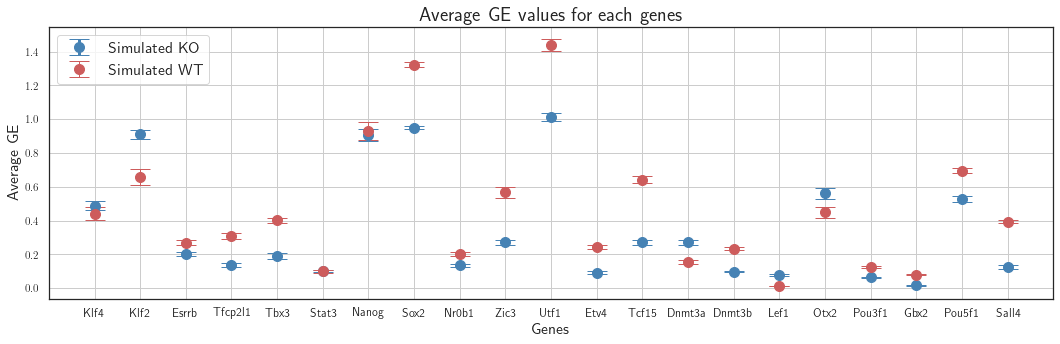

In [65]:
# compute the average and std of the simulated  KO data
KO_Th_df_sim_avg, KO_Th_df_sim_std = funcs_ko.WT_avg_w(KO_df_sim)
KO_Th_df_sim_std = (np.std(KO_df_sim, axis=1)/np.sqrt(KO_df_sim.shape[1]))[:,0]

KO_Th_diff, KO_Th_diff_std, KO_Th_idx_notS = funcs_ko.KO_diff_sim(KO_Th_df_sim_avg, KO_Th_df_sim_std ,KO_Th_wt_avg, KO_Th_wt_std, thr_significance=3)
# KO_Th_genes_order_sel = KO_genes_order[KO_Th_idx_notS]
KO_Th_genes_order_sel = np.delete(KO_genes_order, KO_Th_idx_notS, axis=0)

print("index of genes not significantly different", KO_Th_idx_notS)
print("number of genes significantly different", KO_Th_genes_order_sel.shape)
# print(KO_genes_order)
print(KO_Th_genes_order_sel)

funcs_ko.KO_plots_avgAct_SCODE(KO_Th_df_sim_avg, KO_Th_df_sim_std, KO_Th_wt_avg, KO_Th_wt_std, KO_genes_order, N_sigma=1)



In [66]:
# exp logFC
# df_tKO_Kalkan = pd.read_csv(path_data+'Kalkan_Data/df_tripleKO.csv', index_col=0, header=0)

df_tKO_Kalkan = pd.read_csv(path_data+'Kalkan_Data/df_tripleKO_diff.csv', index_col=0, header=0)
# remove row of the KO
df_tKO_Kalkan_sel =df_tKO_Kalkan.drop(["Etv5", "Rbpj", "Tcf7l1"])
# search gene present in genes_order and absent in df_tKO_Kalkan_sel and thei indices
common_genes = [x for x in KO_genes_order if x in df_tKO_Kalkan_sel.index]
common_genes_idx = [x for x in range(len(KO_genes_order)) if KO_genes_order[x] in df_tKO_Kalkan_sel.index]
print(common_genes)



['Klf4', 'Klf2', 'Esrrb', 'Tfcp2l1', 'Tbx3', 'Stat3', 'Nanog', 'Sox2', 'Nr0b1', 'Zic3', 'Utf1', 'Etv4', 'Tcf15', 'Dnmt3a', 'Dnmt3b', 'Lef1', 'Otx2', 'Pou3f1', 'Gbx2', 'Pou5f1', 'Sall4']


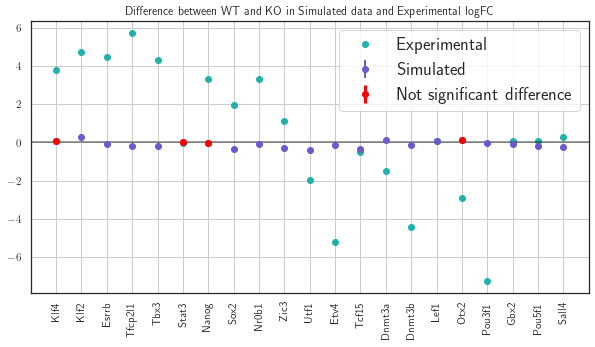

In [67]:

# select only the genes present in df_tKO_Kalkan_sel
KO_Th_diff_temp = KO_Th_diff[np.array([x for x in range(len(KO_genes_order)) if KO_genes_order[x] in df_tKO_Kalkan_sel.index])]
KO_Th_diff_std_temp = KO_Th_diff_std[np.array([x for x in range(len(KO_genes_order)) if KO_genes_order[x] in df_tKO_Kalkan_sel.index])]
KO_genes_order_temp = np.array([x for x in KO_genes_order if x in df_tKO_Kalkan_sel.index])
KO_genes_order_temp_idx = np.array([x for x in range(len(KO_genes_order)) if KO_genes_order[x] in df_tKO_Kalkan_sel.index])
# select only indices KO_Th_idx_notS present in KO_genes_order_temp
sel_idxs_KO = np.intersect1d(KO_genes_order_temp, KO_genes_order[KO_Th_idx_notS])
sel_idxs_KO = np.array([x for x in range(len(df_tKO_Kalkan_sel.index)) if df_tKO_Kalkan_sel.index[x] in sel_idxs_KO])
funcs_ko.KO_plof_Diff_LogFC(df_tKO_Kalkan_sel, KO_Th_diff_temp, KO_Th_diff_std_temp, KO_genes_order_temp, sel_idxs_KO, 'Difference between WT and KO in Simulated data and Experimental logFC')

KO_Th_diff = np.delete(KO_Th_diff, KO_Th_idx_notS, axis=0)
KO_Th_diff_std = np.delete(KO_Th_diff_std, KO_Th_idx_notS, axis=0)
# search gene present in genes_order and absent in df_tKO_Kalkan
common_genes = np.array([x for x in KO_Th_genes_order_sel if x in df_tKO_Kalkan_sel.index])

# indices of genes_order corresponding to common_genes
common_genes_idx = np.array([x for x in range(len(KO_Th_genes_order_sel)) if KO_Th_genes_order_sel[x] in df_tKO_Kalkan_sel.index])

# select only simulated KO and WT for which we know experimental tKO
# differences for the considered genes
KO_Th_diff_sel = KO_Th_diff[common_genes_idx]
KO_Th_diff_std_sel = KO_Th_diff_std[common_genes_idx]

df_tKO_Kalkan_sel = df_tKO_Kalkan_sel.loc[common_genes]
df_tKO_Kalkan_sel = np.squeeze(np.array(df_tKO_Kalkan_sel.iloc[:,0]))

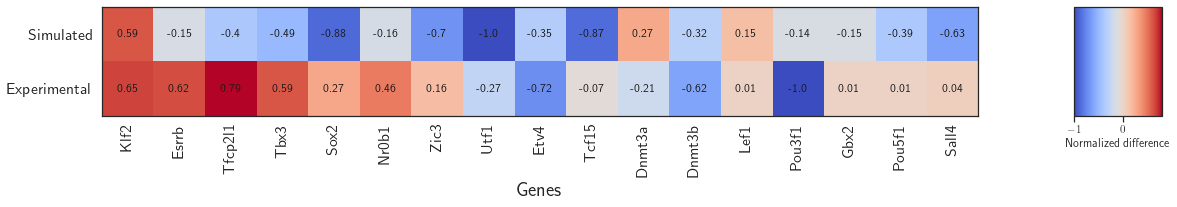

In [68]:
funcs_ko.KO_heat_comparison_T(KO_Th_diff, np.array(df_tKO_Kalkan_sel).squeeze(), "", np.array(common_genes), Norm=True)


KO_std-wt_std not significant for gene  []
in agreement 0.4117647058823529
data considered 17
considered genes ['Klf2' 'Esrrb' 'Tfcp2l1' 'Tbx3' 'Sox2' 'Nr0b1' 'Zic3' 'Utf1' 'Etv4'
 'Tcf15' 'Dnmt3a' 'Dnmt3b' 'Lef1' 'Pou3f1' 'Gbx2' 'Pou5f1' 'Sall4']


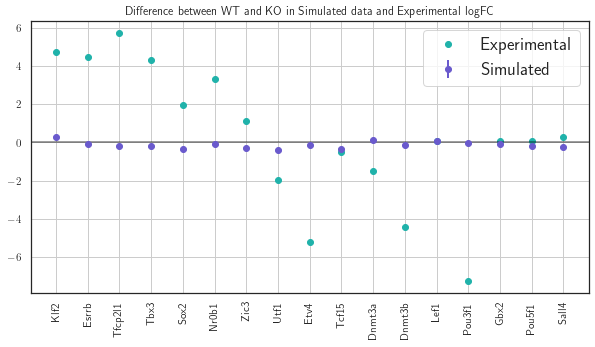

In [69]:

# in_agreement_pN_T, data_considered_pN_T, considered_genes_pN_T = funcs_ko.KO_diff_ExpVsSim(df_tKO_Kalkan_sel, KO_Th_diff_sel, KO_Th_diff_std_sel, common_genes)
# print("in agreement", in_agreement_pN_T)
# print("data considered", data_considered_pN_T)
# print("considered genes", considered_genes_pN_T)

# funcs_ko.KO_plof_Diff_LogFC(df_tKO_Kalkan_sel, KO_Th_diff_sel, KO_Th_diff_std_sel, common_genes, [], 'Difference between WT and KO in Simulated data and Experimental logFC')



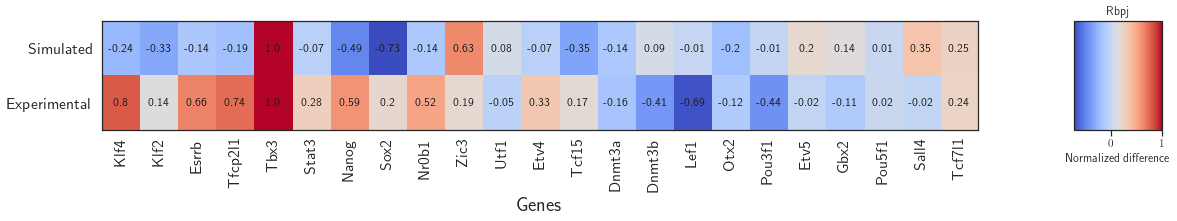

(0.08695652173913043, 0.13043478260869565, 0.043478260869565216, 0.2608695652173913)


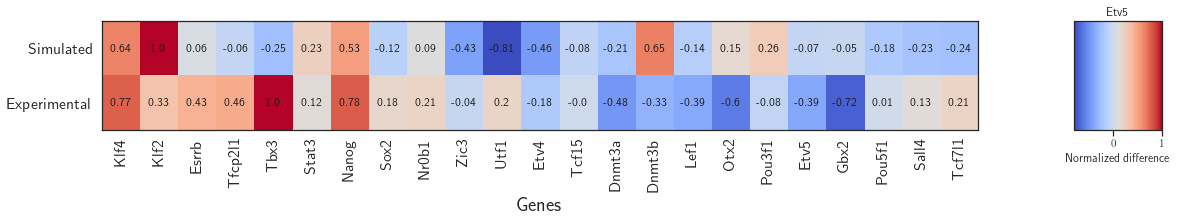

(0.17391304347826086, 0.2608695652173913, 0.0, 0.43478260869565216)


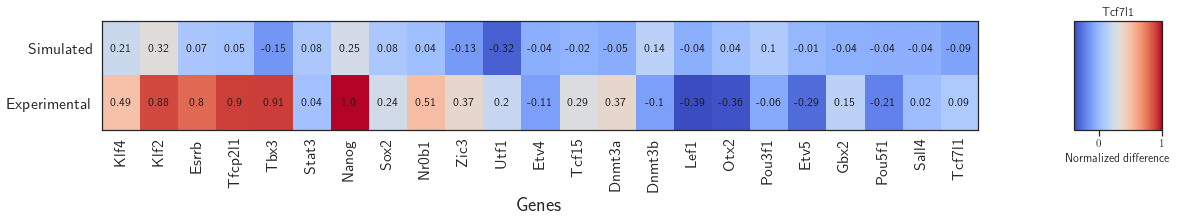

(0.0, 0.2608695652173913, 0.043478260869565216, 0.30434782608695654)


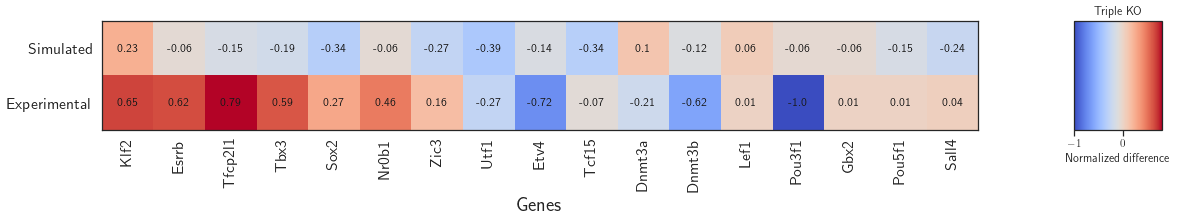

(0.29411764705882354, 0.058823529411764705, 0.0, 0.35294117647058826)


In [99]:
# Normalized differences
diff_sim   = np.array([KO_R_diff, KO_E_diff, KO_T_diff])
log2FC_exp = np.array([logFC_Leeb_R, logFC_Leeb_E, logFC_Leeb_T])
genes_KOs  = np.array([KO_genes_order_R, KO_genes_order_E, KO_genes_order_T])

diff_max = max(np.abs(diff_sim).max(), np.abs(KO_Th_diff).max())
diff_sim_norm = diff_sim/diff_max
diff_sim_T_norm = KO_Th_diff/diff_max

log2FC_exp_norm = log2FC_exp/np.abs(log2FC_exp).max()
df_tKO_Kalkan_norm = df_tKO_Kalkan_sel/np.abs(df_tKO_Kalkan_sel).max()
# diff_pN_Tcf7l1, exp_logFC_Tcf7l1, KO_genes_order_Tcf7l1 

diff_thr = 0.05

# Rbpj
funcs_ko.KO_heat_comparison_T(diff_sim_norm[0,:], log2FC_exp_norm[0,:], "Rbpj", genes_KOs[0,:], Norm=False)
# find common indexes
print(funcs_ko.fraction_agreement(diff_sim_norm[0,:], log2FC_exp_norm[0,:], genes_KOs[0,:], diff_thr))

# Etv5
funcs_ko.KO_heat_comparison_T(diff_sim_norm[1,:], log2FC_exp_norm[1,:], "Etv5", genes_KOs[0,:], Norm=False)
print(funcs_ko.fraction_agreement(diff_sim_norm[1,:], log2FC_exp_norm[1,:], genes_KOs[1,:], diff_thr))

# Tcf7l1
funcs_ko.KO_heat_comparison_T(diff_sim_norm[2,:], log2FC_exp_norm[2,:], "Tcf7l1", genes_KOs[0,:], Norm=False)
print(funcs_ko.fraction_agreement(diff_sim_norm[2,:], log2FC_exp_norm[2,:], genes_KOs[2,:], diff_thr))

# Triple
funcs_ko.KO_heat_comparison_T(diff_sim_T_norm, np.array(df_tKO_Kalkan_norm).squeeze(), "Triple KO", np.array(common_genes), Norm=False)
print(funcs_ko.fraction_agreement(diff_sim_T_norm, np.array(df_tKO_Kalkan_norm).squeeze(), np.array(common_genes), diff_thr))

